In [ ]:
import pandas as pd

In [ ]:
data=pd.read_csv("/content/earthquakes_1950_2024.csv")

In [ ]:
data.head()

,Time,Latitude,Longitude,Magnitude
0,1964-12-30 23:37:44.300,36.13,70.00,4.9
1,1964-12-30 22:39:08.700,-38.70,175.80,4.4
2,1964-12-30 21:30:57.300,-23.33,-179.82,5.0
3,1964-12-30 16:49:49.300,41.30,142.02,4.2
4,1964-12-30 16:35:13.700,-32.64,-179.25,5.0


In [ ]:
data['Time'] = pd.to_datetime(data['Time'])
data = data.sort_values(by='Time').reset_index(drop=True)

In [ ]:
data.head()

,Time,Latitude,Longitude,Magnitude
0,1960-01-01 02:34:48,15.95,-100.13,5.1
1,1960-01-01 23:12:31,56.09,163.02,5.4
2,1960-01-02 03:21:48,-17.68,-69.21,6.2
3,1960-01-02 05:06:57,3.03,95.96,5.8
4,1960-01-02 06:59:36,55.91,163.25,5.6


In [ ]:
# prompt: convert time into Day, Month, Year, Hour, Minute and Second columns

data['Day'] = data['Time'].dt.day
data['Month'] = data['Time'].dt.month
data['Year'] = data['Time'].dt.year
data['Hour'] = data['Time'].dt.hour
data['Minute'] = data['Time'].dt.minute
data['Second'] = data['Time'].dt.second
data.drop('Time', axis=1, inplace=True)


In [ ]:
data.head()

,Latitude,Longitude,Magnitude,Day,Month,Year,Hour,Minute,Second
0,15.95,-100.13,5.1,1,1,1960,2,34,48
1,56.09,163.02,5.4,1,1,1960,23,12,31
2,-17.68,-69.21,6.2,2,1,1960,3,21,48
3,3.03,95.96,5.8,2,1,1960,5,6,57
4,55.91,163.25,5.6,2,1,1960,6,59,36


In [ ]:
data.shape

(693867, 9)

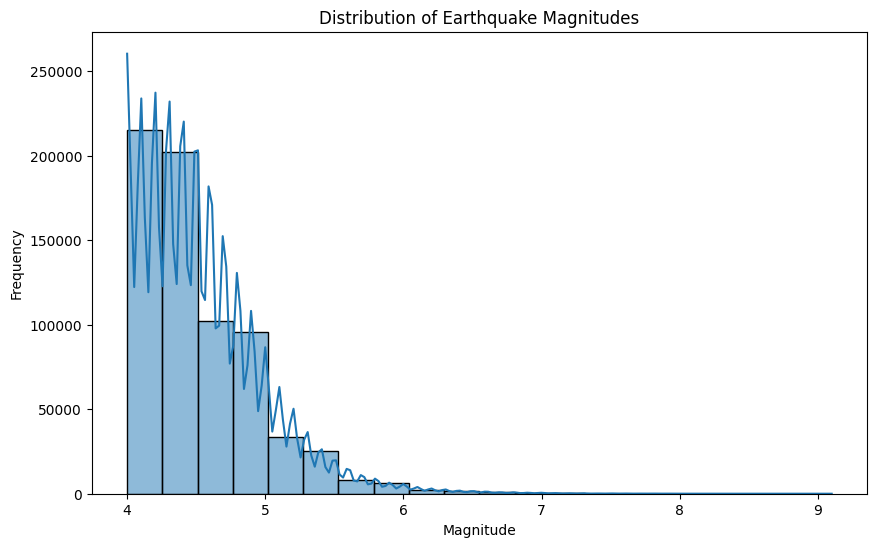

count    693867.000000
mean          4.523986
std           0.441429
min           4.000000
25%           4.200000
50%           4.400000
75%           4.800000
max           9.100000
Name: Magnitude, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data['Magnitude'], bins=20, kde=True)
plt.title('Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()

# Descriptive statistics
print(data['Magnitude'].describe())

**SIMPLE LSTM YEAR**

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 602.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Assuming 'data' contains the necessary features
input_features = ['Magnitude', 'Year']
target = ['Year']

# Normalize features using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(data[input_features])
y_scaled = scaler_y.fit_transform(data[target])

# Create sequences of data for LSTM
def create_sequences(X_data, y_data, seq_length):
    Xs, ys = [], []
    for i in range(len(X_data) - seq_length):
        Xs.append(X_data[i:i+seq_length])
        ys.append(y_data[i+seq_length])  # Target is the next "Year"
    return np.array(Xs), np.array(ys)

# Define the sequence length
seq_length = 30

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# Split the data into train and test sets
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [ ]:
# Build a simple LSTM model
model = Sequential()
model.add(LSTM(10, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predicting a single value (Year)

model.compile(optimizer='adam', loss='mse')

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 61s 9ms/step - loss: 0.0167 - val_loss: 9.5411e-05
Epoch 2/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - loss: 0.0011 - val_loss: 1.0140e-04
Epoch 3/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - loss: 0.0011 - val_loss: 3.1119e-05
Epoch 4/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - loss: 0.0011 - val_loss: 3.3949e-05
Epoch 5/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.0011 - val_loss: 2.5795e-05
Epoch 6/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - loss: 0.0011 - val_loss: 1.3209e-06
Epoch 7/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 0.0011 - val_loss: 1.0374e-04
Epoch 8/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 0.0011 - val_loss: 9.7590e-05
Epoch 9/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - loss: 0.0011 - val_loss: 1.2435e-04
Epoch 10/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - loss: 0.0011 - val_loss: 1.0273e-04
Epoch 11/20
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - loss: 0.001

In [ ]:
model.save('lstm-time-model.h5')

In [ ]:
# Predict on the test set
y_pred_scaled = model.predict(X_test)

# Inverse transform to get the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_pred = np.round(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# Print evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")


4337/4337 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Test MSE: 0.024126599792459357
Test MAE: 0.024126599792459357


In [ ]:
# Optional: Print a few sample predictions
for i in range(10,100000,5000):
    print(f"Prediction {i+1}:")
    print(f"  Predicted Year: {y_pred[i][0]:.2f}")
    print(f"  Actual Year: {y_test_original[i][0]:.2f}")
    print("-" * 50)

Prediction 11:
  Predicted Year: 2015.00
  Actual Year: 2015.00
--------------------------------------------------
Prediction 5011:
  Predicted Year: 2015.00
  Actual Year: 2015.00
--------------------------------------------------
Prediction 10011:
  Predicted Year: 2015.00
  Actual Year: 2015.00
--------------------------------------------------
Prediction 15011:
  Predicted Year: 2015.00
  Actual Year: 2015.00
--------------------------------------------------
Prediction 20011:
  Predicted Year: 2016.00
  Actual Year: 2016.00
--------------------------------------------------
Prediction 25011:
  Predicted Year: 2016.00
  Actual Year: 2016.00
--------------------------------------------------
Prediction 30011:
  Predicted Year: 2016.00
  Actual Year: 2016.00
--------------------------------------------------
Prediction 35011:
  Predicted Year: 2017.00
  Actual Year: 2017.00
--------------------------------------------------
Prediction 40011:
  Predicted Year: 2017.00
  Actual Year: 2